In [76]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, History
from sklearn.metrics import classification_report
import numpy as np
import os
import time
from matplotlib import pyplot
import tensorflow as tf

In [2]:
def DataSplit(x_total_addr, y_total_addr, val_ratio = 0.2):
    x_total = np.load(x_total_addr)
    y_total = np.load(y_total_addr)
    index_split = int(x_total.shape[0]*0.8)
    x_train = x_total[:index_split]
    y_train = y_total[:index_split]
    x_val = x_total[index_split:]
    y_val = y_total[index_split:]
    print("x_total: ", x_total.shape, "y_total: ", y_total.shape, 
          "x_train length: ", x_train.shape, "y_train length: ", y_train.shape, 
          "x_val length: ", x_val.shape, "y_val length: ", y_val.shape)
    return x_train, y_train, x_val, y_val

In [31]:
########### Stateless LSTM ############
x_train, y_train,x_val, y_val = DataSplit("x_shuffled_0.npy", "y_shuffled_0.npy")

data_dim = x_train.shape[2] #2
timesteps = x_train.shape[1] #60
nb_classes = len(np.unique(y_train)) #5

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
##################################### Helpers in callbacks ##############################################
tb = TensorBoard(log_dir=os.path.join('tensorboard', 'logs',))
early_stopper = EarlyStopping(patience=5)
csv_logger = CSVLogger(os.path.join('logs', str(time.time()) + '.log'))
checkpointer = ModelCheckpoint(filepath=os.path.join('checkpoints','{epoch:03d}-{val_sparse_categorical_accuracy:.3f}.hdf5'),
                                verbose=1,save_best_only=True)
history = History()
#########################################################################################################
hist = model.fit(x_train, y_train,
          batch_size=64, nb_epoch=100,
          validation_data=(x_val, y_val),
          callbacks=[tb, early_stopper, csv_logger, checkpointer, history])

x_total:  (5103, 60, 2) y_total:  (5103,) x_train length:  (4082, 60, 2) y_train length:  (4082,) x_val length:  (1021, 60, 2) y_val length:  (1021,)


C:\Users\Yue Ma\Anaconda\lib\site-packages\ipykernel\__main__.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4082 samples, validate on 1021 samples
Epoch 1/100
4082/4082 [==============================] - 16s 4ms/step - loss: 1.5521 - sparse_categorical_accuracy: 0.2974 - val_loss: 1.5175 - val_sparse_categorical_accuracy: 0.3428

Epoch 00001: val_loss improved from inf to 1.51749, saving model to checkpoints\001-0.343.hdf5
Epoch 2/100
4082/4082 [==============================] - 13s 3ms/step - loss: 1.4964 - sparse_categorical_accuracy: 0.3481 - val_loss: 1.4562 - val_sparse_categorical_accuracy: 0.3643

Epoch 00002: val_loss improved from 1.51749 to 1.45616, saving model to checkpoints\002-0.364.hdf5
Epoch 3/100
4082/4082 [==============================] - 14s 4ms/step - loss: 1.4659 - sparse_categorical_accuracy: 0.3520 - val_loss: 1.4438 - val_sparse_categorical_accuracy: 0.3898

Epoch 00003: val_loss improved from 1.45616 to 1.44381, saving model to checkpoints\003-0.390.hdf5
Epoch 4/100
4082/4082 [==============================] - 13s 3ms/step - loss: 1.4564 - sparse_categorica


Epoch 00031: val_loss did not improve from 1.29466
Epoch 32/100
4082/4082 [==============================] - 13s 3ms/step - loss: 1.2796 - sparse_categorical_accuracy: 0.4691 - val_loss: 1.3222 - val_sparse_categorical_accuracy: 0.4613

Epoch 00032: val_loss did not improve from 1.29466
Epoch 33/100
4082/4082 [==============================] - 13s 3ms/step - loss: 1.2763 - sparse_categorical_accuracy: 0.4782 - val_loss: 1.3136 - val_sparse_categorical_accuracy: 0.4613

Epoch 00033: val_loss did not improve from 1.29466


In [34]:
########### Stateful LSTM ############
x_train, y_train,x_val, y_val = DataSplit("x_shuffled_0.npy", "y_shuffled_0.npy")
x_train = x_train[:4080]
y_train = y_train[:4080]
x_val = x_val[:1016]
y_val = y_val[:1016]

data_dim = x_train.shape[2] #2
timesteps = x_train.shape[1] #60
nb_classes = len(np.unique(y_train)) #5
batch_size = 8

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
##################################### Helpers in callbacks ##############################################
tb = TensorBoard(log_dir=os.path.join('tensorboard', 'logs',))
early_stopper = EarlyStopping(patience=5)
csv_logger = CSVLogger(os.path.join('logs', str(time.time()) + '.log'))
checkpointer = ModelCheckpoint(filepath=os.path.join('checkpoints','{epoch:03d}-{val_sparse_categorical_accuracy:.3f}.hdf5'),
                                verbose=1,save_best_only=True)
history = History()
#########################################################################################################
hist = model.fit(x_train, y_train,
          batch_size=batch_size, nb_epoch=100,
          validation_data=(x_val, y_val),
          callbacks=[tb, early_stopper, csv_logger, checkpointer, history])


x_total:  (5103, 60, 2) y_total:  (5103,) x_train length:  (4082, 60, 2) y_train length:  (4082,) x_val length:  (1021, 60, 2) y_val length:  (1021,)


C:\Users\Yue Ma\Anaconda\lib\site-packages\ipykernel\__main__.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4080 samples, validate on 1016 samples
Epoch 1/100
4080/4080 [==============================] - 40s 10ms/step - loss: 1.5515 - sparse_categorical_accuracy: 0.3015 - val_loss: 1.5401 - val_sparse_categorical_accuracy: 0.2844

Epoch 00001: val_loss improved from inf to 1.54007, saving model to checkpoints\001-0.284.hdf5
Epoch 2/100
4080/4080 [==============================] - 37s 9ms/step - loss: 1.4673 - sparse_categorical_accuracy: 0.3434 - val_loss: 1.4736 - val_sparse_categorical_accuracy: 0.3927

Epoch 00002: val_loss improved from 1.54007 to 1.47362, saving model to checkpoints\002-0.393.hdf5
Epoch 3/100
4080/4080 [==============================] - 37s 9ms/step - loss: 1.4212 - sparse_categorical_accuracy: 0.3718 - val_loss: 1.3848 - val_sparse_categorical_accuracy: 0.4045

Epoch 00003: val_loss improved from 1.47362 to 1.38482, saving model to checkpoints\003-0.405.hdf5
Epoch 4/100
4080/4080 [==============================] - 37s 9ms/step - loss: 1.3957 - sparse_categoric

4080/4080 [==============================] - 41s 10ms/step - loss: 1.1448 - sparse_categorical_accuracy: 0.5353 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.4852 - spars

Epoch 00031: val_loss did not improve from 1.21579
Epoch 32/100
4080/4080 [==============================] - 47s 12ms/step - loss: 1.1442 - sparse_categorical_accuracy: 0.5355 - val_loss: 1.2399 - val_sparse_categorical_accuracy: 0.5039

Epoch 00032: val_loss did not improve from 1.21579
Epoch 33/100
4080/4080 [==============================] - 40s 10ms/step - loss: 1.1379 - sparse_categorical_accuracy: 0.5395 - val_loss: 1.2605 - val_sparse_categorical_accuracy: 0.4813

Epoch 00033: val_loss did not improve from 1.21579
Epoch 34/100
4080/4080 [==============================] - 39s 10ms/step - loss: 1.1264 - sparse_categorical_accuracy: 0.5453 - val_loss: 1.2443 - val_sparse_categorical_accuracy: 0.5030

Epoch 00034: val_loss did not improve from 1.21579


In [113]:
def DataTwoStream(x_total_addr, y_total_addr, val_ratio = 0.2):
    x_total = np.load(x_total_addr)
    y_total = np.load(y_total_addr)
    index_split = int(x_total.shape[0]*0.8)
    x_train_a = x_total[:index_split,:,0]
    x_train_a = x_train_a.reshape((x_train_a.shape[0],x_train_a.shape[1],1))
    x_train_b = x_total[:index_split,:,1]
    x_train_b =x_train_b.reshape((x_train_a.shape[0],x_train_a.shape[1],1))
    y_train = y_total[:index_split]
    x_val_a = x_total[:index_split,:,0]
    x_val_a = x_val_a.reshape((x_val_a.shape[0],x_val_a.shape[1],1))
    x_val_b = x_total[:index_split,:,1]
    x_val_b = x_val_b.reshape((x_val_a.shape[0],x_val_a.shape[1],1))
    y_val = y_total[:index_split]
    return x_train_a, x_train_b, y_train, x_val_a, x_val_b, y_val

x_train_a.shape (4082, 60, 1)
x_val_a.shape (4082, 60, 1)
y_val_a.shape (4082,)


In [139]:
####### Two merged LSTM encoders #####################
x_train_a, x_train_b, y_train, x_val_a, x_val_b, y_val = DataTwoStream("x_shuffled_0.npy", "y_shuffled_0.npy")
data_dim = 1
timesteps = x_train.shape[1] #60
nb_classes = len(np.unique(y_train)) #5

first_input = Input((timesteps, data_dim))
encoder_a = LSTM(32, return_sequences=True,
                 batch_input_shape=(batch_size,timesteps, data_dim))(first_input)
encoder_a = Dropout(0.2)(encoder_a)
encoder_a = LSTM(32)(encoder_a)
encoder_a_out = Dropout(0.2)(encoder_a)
model_a = Model(first_input, encoder_a_out)

second_input = Input((timesteps, data_dim))
encoder_b = LSTM(32, return_sequences=True,
                 batch_input_shape=(batch_size, timesteps, data_dim))(second_input)
encoder_b = Dropout(0.2)(encoder_b)
encoder_b = LSTM(32)(encoder_b)
encoder_b_out = Dropout(0.2)(encoder_b)
model_b = Model(second_input, encoder_b_out)

concatenated = concatenate([encoder_a_out, encoder_b_out])
decoder = Dense(32, activation='relu')(concatenated)
output_layer = Dense(nb_classes, activation='softmax')(decoder)

model = Model([first_input, second_input], output_layer)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
##################################### Helpers in callbacks ##############################################
tb = TensorBoard(log_dir=os.path.join('tensorboard', 'logs',))
early_stopper = EarlyStopping(patience=20)
csv_logger = CSVLogger(os.path.join('logs', str(time.time()) + '.log'))
checkpointer = ModelCheckpoint(filepath=os.path.join('checkpoints','{epoch:03d}-{val_sparse_categorical_accuracy:.3f}.hdf5'),
                                verbose=1,save_best_only=True)
history = History()
#########################################################################################################
hist = model.fit([x_train_a, x_train_b], y_train,
            batch_size=64, epochs=500, 
            validation_data=([x_val_a, x_val_b], y_val),
            callbacks=[tb, early_stopper, csv_logger, checkpointer, history])

Train on 4082 samples, validate on 4082 samples
Epoch 1/500
4082/4082 [==============================] - 29s 7ms/step - loss: 1.5471 - sparse_categorical_accuracy: 0.3099 - val_loss: 1.4738 - val_sparse_categorical_accuracy: 0.3503

Epoch 00001: val_loss improved from inf to 1.47383, saving model to checkpoints\001-0.350.hdf5
Epoch 2/500
4082/4082 [==============================] - 19s 5ms/step - loss: 1.4698 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.4651 - val_sparse_categorical_accuracy: 0.3361

Epoch 00002: val_loss improved from 1.47383 to 1.46508, saving model to checkpoints\002-0.336.hdf5
Epoch 3/500
4082/4082 [==============================] - 17s 4ms/step - loss: 1.4591 - sparse_categorical_accuracy: 0.3596 - val_loss: 1.4428 - val_sparse_categorical_accuracy: 0.3704

Epoch 00003: val_loss improved from 1.46508 to 1.44279, saving model to checkpoints\003-0.370.hdf5
Epoch 4/500
4082/4082 [==============================] - 14s 3ms/step - loss: 1.4496 - sparse_categorica

4082/4082 [==============================] - 17s 4ms/step - loss: 1.2696 - sparse_categorical_accuracy: 0.4669 - val_loss: 1.2325 - val_sparse_categorical_accuracy: 0.4804

Epoch 00031: val_loss improved from 1.24221 to 1.23248, saving model to checkpoints\031-0.480.hdf5
Epoch 32/500
4082/4082 [==============================] - 17s 4ms/step - loss: 1.2642 - sparse_categorical_accuracy: 0.4711 - val_loss: 1.2435 - val_sparse_categorical_accuracy: 0.4777

Epoch 00032: val_loss did not improve from 1.23248
Epoch 33/500
4082/4082 [==============================] - 15s 4ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.4740 - val_loss: 1.2380 - val_sparse_categorical_accuracy: 0.4731

Epoch 00033: val_loss did not improve from 1.23248
Epoch 34/500
4082/4082 [==============================] - 15s 4ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.2378 - val_sparse_categorical_accuracy: 0.4767

Epoch 00034: val_loss did not improve from 1.23248
Epoch 35/500
4082

4082/4082 [==============================] - 13s 3ms/step - loss: 1.1585 - sparse_categorical_accuracy: 0.5125 - val_loss: 1.1165 - val_sparse_categorical_accuracy: 0.5345

Epoch 00063: val_loss improved from 1.12858 to 1.11652, saving model to checkpoints\063-0.535.hdf5
Epoch 64/500
4082/4082 [==============================] - 13s 3ms/step - loss: 1.1663 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.1341 - val_sparse_categorical_accuracy: 0.5360

Epoch 00064: val_loss did not improve from 1.11652
Epoch 65/500
4082/4082 [==============================] - 13s 3ms/step - loss: 1.1578 - sparse_categorical_accuracy: 0.5162 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.5424

Epoch 00065: val_loss improved from 1.11652 to 1.11486, saving model to checkpoints\065-0.542.hdf5
Epoch 66/500
4082/4082 [==============================] - 13s 3ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.5184 - val_loss: 1.1054 - val_sparse_categorical_accuracy: 0.5473

Epoch 00066: val_los

4082/4082 [==============================] - 13s 3ms/step - loss: 1.0699 - sparse_categorical_accuracy: 0.5652 - val_loss: 1.0219 - val_sparse_categorical_accuracy: 0.5813

Epoch 00095: val_loss did not improve from 1.01576
Epoch 96/500
4082/4082 [==============================] - 13s 3ms/step - loss: 1.0595 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.0306 - val_sparse_categorical_accuracy: 0.5823

Epoch 00096: val_loss did not improve from 1.01576
Epoch 97/500
4082/4082 [==============================] - 13s 3ms/step - loss: 1.0563 - sparse_categorical_accuracy: 0.5664 - val_loss: 0.9981 - val_sparse_categorical_accuracy: 0.5977

Epoch 00097: val_loss improved from 1.01576 to 0.99809, saving model to checkpoints\097-0.598.hdf5
Epoch 98/500
4082/4082 [==============================] - 13s 3ms/step - loss: 1.0650 - sparse_categorical_accuracy: 0.5512 - val_loss: 0.9883 - val_sparse_categorical_accuracy: 0.5975

Epoch 00098: val_loss improved from 0.99809 to 0.98831, saving model

4082/4082 [==============================] - 13s 3ms/step - loss: 0.9762 - sparse_categorical_accuracy: 0.5955 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.6325

Epoch 00127: val_loss did not improve from 0.89397
Epoch 128/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.9746 - sparse_categorical_accuracy: 0.6022 - val_loss: 0.9078 - val_sparse_categorical_accuracy: 0.6286

Epoch 00128: val_loss did not improve from 0.89397
Epoch 129/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.9770 - sparse_categorical_accuracy: 0.5977 - val_loss: 0.9197 - val_sparse_categorical_accuracy: 0.6230

Epoch 00129: val_loss did not improve from 0.89397
Epoch 130/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.9797 - sparse_categorical_accuracy: 0.5980 - val_loss: 0.8995 - val_sparse_categorical_accuracy: 0.6330

Epoch 00130: val_loss did not improve from 0.89397
Epoch 131/500
4082/4082 [==============================] - 13s

4082/4082 [==============================] - 18s 4ms/step - loss: 0.8695 - sparse_categorical_accuracy: 0.6445 - val_loss: 0.8022 - val_sparse_categorical_accuracy: 0.6818

Epoch 00161: val_loss did not improve from 0.77438
Epoch 162/500
4082/4082 [==============================] - 18s 4ms/step - loss: 0.9004 - sparse_categorical_accuracy: 0.6399 - val_loss: 0.8171 - val_sparse_categorical_accuracy: 0.6769

Epoch 00162: val_loss did not improve from 0.77438
Epoch 163/500
4082/4082 [==============================] - 2495s 611ms/step - loss: 0.8855 - sparse_categorical_accuracy: 0.6414 - val_loss: 0.7886 - val_sparse_categorical_accuracy: 0.6906

Epoch 00163: val_loss did not improve from 0.77438
Epoch 164/500
4082/4082 [==============================] - 16s 4ms/step - loss: 0.8844 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.8129 - val_sparse_categorical_accuracy: 0.6727

Epoch 00164: val_loss did not improve from 0.77438
Epoch 165/500
4082/4082 [==============================] -

4082/4082 [==============================] - 14s 3ms/step - loss: 0.8372 - sparse_categorical_accuracy: 0.6639 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.7369

Epoch 00194: val_loss improved from 0.70127 to 0.69357, saving model to checkpoints\194-0.737.hdf5
Epoch 195/500
4082/4082 [==============================] - 16s 4ms/step - loss: 0.8206 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.6853 - val_sparse_categorical_accuracy: 0.7347

Epoch 00195: val_loss improved from 0.69357 to 0.68527, saving model to checkpoints\195-0.735.hdf5
Epoch 196/500
4082/4082 [==============================] - 14s 3ms/step - loss: 0.8220 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.7096 - val_sparse_categorical_accuracy: 0.7286

Epoch 00196: val_loss did not improve from 0.68527
Epoch 197/500
4082/4082 [==============================] - 14s 3ms/step - loss: 0.8209 - sparse_categorical_accuracy: 0.6634 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.7298

Epoch 00197: val_

4082/4082 [==============================] - 13s 3ms/step - loss: 0.7425 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.6189 - val_sparse_categorical_accuracy: 0.7668

Epoch 00227: val_loss did not improve from 0.61870
Epoch 228/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.7465 - sparse_categorical_accuracy: 0.7041 - val_loss: 0.6051 - val_sparse_categorical_accuracy: 0.7729

Epoch 00228: val_loss improved from 0.61870 to 0.60515, saving model to checkpoints\228-0.773.hdf5
Epoch 229/500
4082/4082 [==============================] - 14s 3ms/step - loss: 0.7621 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.7709

Epoch 00229: val_loss did not improve from 0.60515
Epoch 230/500
4082/4082 [==============================] - 14s 4ms/step - loss: 0.7431 - sparse_categorical_accuracy: 0.6997 - val_loss: 0.6067 - val_sparse_categorical_accuracy: 0.7783

Epoch 00230: val_loss did not improve from 0.60515
Epoch 231/500



Epoch 00260: val_loss did not improve from 0.54479
Epoch 261/500
4082/4082 [==============================] - 15s 4ms/step - loss: 0.6883 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.5681 - val_sparse_categorical_accuracy: 0.7856

Epoch 00261: val_loss did not improve from 0.54479
Epoch 262/500
4082/4082 [==============================] - 15s 4ms/step - loss: 0.6742 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.5616 - val_sparse_categorical_accuracy: 0.7923

Epoch 00262: val_loss did not improve from 0.54479
Epoch 263/500
4082/4082 [==============================] - 16s 4ms/step - loss: 0.7030 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.5318 - val_sparse_categorical_accuracy: 0.8055

Epoch 00263: val_loss improved from 0.54479 to 0.53183, saving model to checkpoints\263-0.805.hdf5
Epoch 264/500
4082/4082 [==============================] - 16s 4ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.5342 - val_sparse_categorical_accuracy: 0.8025


4082/4082 [==============================] - 13s 3ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.4856 - val_sparse_categorical_accuracy: 0.8256

Epoch 00293: val_loss did not improve from 0.47061
Epoch 294/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.4822 - val_sparse_categorical_accuracy: 0.8253

Epoch 00294: val_loss did not improve from 0.47061
Epoch 295/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.5082 - val_sparse_categorical_accuracy: 0.8097

Epoch 00295: val_loss did not improve from 0.47061
Epoch 296/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.4593 - val_sparse_categorical_accuracy: 0.8344

Epoch 00296: val_loss improved from 0.47061 to 0.45927, saving model to checkpoints\296-0.834.hdf5
Epoch 297/500


4082/4082 [==============================] - 13s 3ms/step - loss: 0.5934 - sparse_categorical_accuracy: 0.7675 - val_loss: 0.4339 - val_sparse_categorical_accuracy: 0.8403

Epoch 00326: val_loss did not improve from 0.42732
Epoch 327/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.7658 - val_loss: 0.4117 - val_sparse_categorical_accuracy: 0.8555

Epoch 00327: val_loss improved from 0.42732 to 0.41172, saving model to checkpoints\327-0.855.hdf5
Epoch 328/500
4082/4082 [==============================] - 14s 4ms/step - loss: 0.5895 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.4029 - val_sparse_categorical_accuracy: 0.8560

Epoch 00328: val_loss improved from 0.41172 to 0.40287, saving model to checkpoints\328-0.856.hdf5
Epoch 329/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5873 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8584

Epoch 00329: val_

4082/4082 [==============================] - 12s 3ms/step - loss: 0.5489 - sparse_categorical_accuracy: 0.7829 - val_loss: 0.3914 - val_sparse_categorical_accuracy: 0.8655

Epoch 00359: val_loss did not improve from 0.37260
Epoch 360/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5403 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.3719 - val_sparse_categorical_accuracy: 0.8689

Epoch 00360: val_loss improved from 0.37260 to 0.37193, saving model to checkpoints\360-0.869.hdf5
Epoch 361/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5608 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8667

Epoch 00361: val_loss did not improve from 0.37193
Epoch 362/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5465 - sparse_categorical_accuracy: 0.7918 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.8626

Epoch 00362: val_loss did not improve from 0.37193
Epoch 363/500


4082/4082 [==============================] - 12s 3ms/step - loss: 0.5241 - sparse_categorical_accuracy: 0.7986 - val_loss: 0.3673 - val_sparse_categorical_accuracy: 0.8721

Epoch 00392: val_loss did not improve from 0.32718
Epoch 393/500
4082/4082 [==============================] - 12s 3ms/step - loss: 0.5212 - sparse_categorical_accuracy: 0.7981 - val_loss: 0.3375 - val_sparse_categorical_accuracy: 0.8858

Epoch 00393: val_loss did not improve from 0.32718
Epoch 394/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5247 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.3147 - val_sparse_categorical_accuracy: 0.8949

Epoch 00394: val_loss improved from 0.32718 to 0.31468, saving model to checkpoints\394-0.895.hdf5
Epoch 395/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.5096 - sparse_categorical_accuracy: 0.8021 - val_loss: 0.3703 - val_sparse_categorical_accuracy: 0.8623

Epoch 00395: val_loss did not improve from 0.31468
Epoch 396/500



Epoch 00425: val_loss did not improve from 0.28816
Epoch 426/500
4082/4082 [==============================] - 12s 3ms/step - loss: 0.4771 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.9072

Epoch 00426: val_loss did not improve from 0.28816
Epoch 427/500
4082/4082 [==============================] - 12s 3ms/step - loss: 0.4543 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.8996

Epoch 00427: val_loss did not improve from 0.28816
Epoch 428/500
4082/4082 [==============================] - 12s 3ms/step - loss: 0.4766 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.2958 - val_sparse_categorical_accuracy: 0.9015

Epoch 00428: val_loss did not improve from 0.28816
Epoch 429/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.4608 - sparse_categorical_accuracy: 0.8234 - val_loss: 0.2827 - val_sparse_categorical_accuracy: 0.9138

Epoch 00429: val_loss improved from 0.28816 to 

4082/4082 [==============================] - 12s 3ms/step - loss: 0.4448 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.2409 - val_sparse_categorical_accuracy: 0.9277

Epoch 00459: val_loss improved from 0.26003 to 0.24088, saving model to checkpoints\459-0.928.hdf5
Epoch 460/500
4082/4082 [==============================] - 14s 3ms/step - loss: 0.4336 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.2738 - val_sparse_categorical_accuracy: 0.9094

Epoch 00460: val_loss did not improve from 0.24088
Epoch 461/500
4082/4082 [==============================] - 14s 3ms/step - loss: 0.4640 - sparse_categorical_accuracy: 0.8278 - val_loss: 0.2612 - val_sparse_categorical_accuracy: 0.9130

Epoch 00461: val_loss did not improve from 0.24088
Epoch 462/500
4082/4082 [==============================] - 15s 4ms/step - loss: 0.4403 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.3372 - val_sparse_categorical_accuracy: 0.8824

Epoch 00462: val_loss did not improve from 0.24088
Epoch 463/500



Epoch 00492: val_loss did not improve from 0.21725
Epoch 493/500
4082/4082 [==============================] - 15s 4ms/step - loss: 0.4085 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.2154 - val_sparse_categorical_accuracy: 0.9346

Epoch 00493: val_loss improved from 0.21725 to 0.21542, saving model to checkpoints\493-0.935.hdf5
Epoch 494/500
4082/4082 [==============================] - 14s 3ms/step - loss: 0.4289 - sparse_categorical_accuracy: 0.8344 - val_loss: 0.2356 - val_sparse_categorical_accuracy: 0.9236

Epoch 00494: val_loss did not improve from 0.21542
Epoch 495/500
4082/4082 [==============================] - 12s 3ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.8439 - val_loss: 0.2180 - val_sparse_categorical_accuracy: 0.9336

Epoch 00495: val_loss did not improve from 0.21542
Epoch 496/500
4082/4082 [==============================] - 13s 3ms/step - loss: 0.4208 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.2421 - val_sparse_categorical_accuracy: 0.9219


In [138]:
####### Single LSTM encoder with two parallel sequences #####################
x_train_a, x_train_b, y_train, x_val_a, x_val_b, y_val = DataTwoStream("x_shuffled_0.npy", "y_shuffled_0.npy")
data_dim = 1
timesteps = x_train.shape[1] #60
nb_classes = len(np.unique(y_train)) #5

first_input = Input((timesteps, data_dim))
second_input = Input((timesteps, data_dim))
concatenated = concatenate([first_input, second_input])

lstm = LSTM(32, return_sequences=True,
                 batch_input_shape=(batch_size, timesteps, data_dim))(concatenated)
lstm = Dropout(0.2)(lstm)
lstm = LSTM(32)(lstm)
lstm = Dropout(0.2)(lstm)
dense = Dense(32, activation='relu')(lstm)
output_layer = Dense(nb_classes, activation='softmax')(dense)

model = Model([first_input, second_input], output_layer)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

ImportError: cannot import name 'Graph'

Save models afterwards

In [143]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [146]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("best.hdf5")
loaded_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
score = loaded_model.evaluate([x_val_a, x_val_b], y_val, verbose=0, batch_size = 8)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

sparse_categorical_accuracy: 93.46%


In [147]:
y_pred = loaded_model.predict([x_val_a, x_val_b])
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      1015
         1.0       0.90      0.91      0.90       646
         2.0       0.88      0.93      0.91       769
         3.0       0.94      0.94      0.94       855
         4.0       0.94      0.94      0.94       797

   micro avg       0.93      0.93      0.93      4082
   macro avg       0.93      0.93      0.93      4082
weighted avg       0.94      0.93      0.93      4082



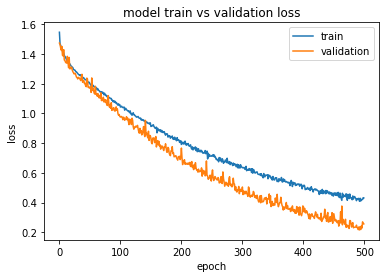

In [148]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

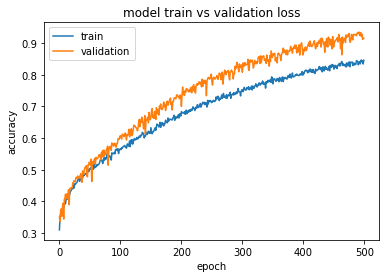

In [149]:
pyplot.plot(history.history['sparse_categorical_accuracy'])
pyplot.plot(history.history['val_sparse_categorical_accuracy'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()

In [37]:
y_pred = loaded_model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1015
         1.0       1.00      1.00      1.00       646
         2.0       1.00      1.00      1.00       769
         3.0       1.00      1.00      1.00       855
         4.0       1.00      1.00      1.00       797

   micro avg       1.00      1.00      1.00      4082
   macro avg       1.00      1.00      1.00      4082
weighted avg       1.00      1.00      1.00      4082



In [34]:
y_pred_final = np.argmax(y_pred, axis=1)

In [33]:
x_val.shape

(1021, 60, 2)

In [103]:
y_val_

0.0